# Outcome and Feature Construction
Generate the class values, i.e. the y for the data. Construct features

The following dataframes are generated:
- source
- features
- outcomes

## Parameters
Here, all parameters of the notebook are set

In [1]:
use_training_settings = False
dataset_name = "omxs30"
class_name = "LongTrend"

if use_training_settings == True:
    #Load stock market files 
    filename = '01_Source/Source_OMX1986-2019.CSV'
    filedataresultdirectory = "02_Training_Data"
    
    filenameprefix = dataset_name + "_" + class_name
    filenamesuffix = ""
    
    #Allow cropping of data, which are longer than moving averages in the future. For training data, this value shall be 
    #true to not make false values. For the test values, which do not use any y values, the value shall be false.
    cut_data = True
else:
    ### FOR TEST DATA ###
    filename = '01_Source/Source_OMX2017-2019_testset.CSV'
    filedataresultdirectory = "03_Test_Prepared_Data"
    
    filenameprefix = dataset_name + "_" + class_name
    filenamesuffix = "_test" #Add test to the test files

    #Allow cropping of data, which are longer than moving averages in the future. For training data, this value shall be 
    #true to not make false values. For the test values, which do not use any y values, the value shall be false.
    cut_data = False

In [2]:
dataset_filename = filedataresultdirectory + "/" + filenameprefix + "_dataset" + filenamesuffix + ".csv"
ylabel_filename = filedataresultdirectory + "/" + filenameprefix + "_y" + "_labels" + filenamesuffix + ".csv"
source_filename = filedataresultdirectory + "/" + filenameprefix + "_timegraph" + filenamesuffix + ".csv"

## Load Raw Data
Stock data will be loaded, train and test values will be calculated to be used as Y values for the system

<IPython.core.display.Javascript object>


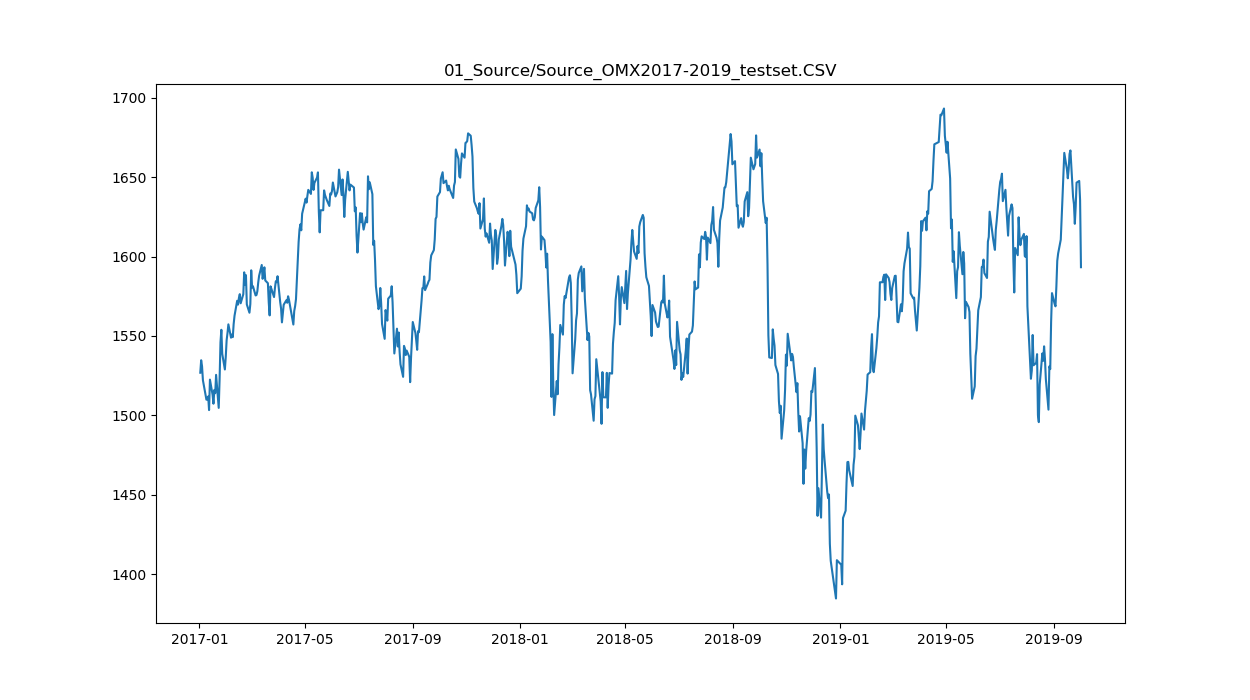

In [3]:
%matplotlib notebook

import pandas as pd
import numpy as np
# import pandas_datareader as datareader
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

import DatavisualizationFunctions as vis
#from matplotlib.finance import candlestick_ohlc
# from mpl_finance import candlestick_ohlc

#%matplotlib inline
#%matplotlib notebook
#%matplotlib ipympl

source = pd.read_csv(filename, sep=';')
source.index.name = "id"
source.columns = ['Time', 'High', 'Low', 'Close']
source['Time'] = pd.to_datetime(source['Time'])
source['Time'].apply(mdates.date2num)
#df.head()

plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(source['Time'],source['Close'])
plt.title(filename)
plt.show()

## Class Generation

Here, 4 classes will be generated:
- LongTerm
- Intermediate term 20d
- Short term 5d
- very short term 1d

#### Create labels

In [4]:
y_labels = {
    'neutral' : 0,
    'positive' : 1,
    'negative':  2
}

### Calculate Tops and Bottoms

In [5]:
m=source.shape[0]
factor = 10000000
topsTemp = np.zeros([m, 4]);
topsTemp
bottomsTemp = np.ones([m, 4])*factor;
bottomsTemp
#close=source['Close']
#close

array([[10000000., 10000000., 10000000., 10000000.],
       [10000000., 10000000., 10000000., 10000000.],
       [10000000., 10000000., 10000000., 10000000.],
       ...,
       [10000000., 10000000., 10000000., 10000000.],
       [10000000., 10000000., 10000000., 10000000.],
       [10000000., 10000000., 10000000., 10000000.]])

In [6]:
# Get tops and bottoms from the chart
#Parameter
maxDecline = 0.02
maxIncrease = 0.02
factor = 10000000

#Format: Time, High, Low, Close
m=source.shape[0]

topsTemp = np.zeros([m, 4])
bottomsTemp = np.ones([m, 4])*factor

high=source['High']
low=source['Low']
close=source['Close']

#Run 1 for the rough tops and bottoms
for i, data in enumerate(source.values):
    #Get top
    if i>3 and i<m-3:
        #Decline close >2% from top high
        decline = (high[i] - min(close[i+1:i+2]))/high[i];
        if decline > maxDecline or high[i]==max(high[i-3:i+3]):
            #Top found
            topsTemp[i, 1]=high[i];
            #print("Top found at i={} value={}".format(i, high[i]));
    
    #%Get bottom
    if i>3 and i<m-3:
    #    %Decline close >2% from top high
        increase = (low[i] - max(close[i+1:i+2]))/low[i];
        if increase > maxIncrease or low[i]==min(low[i-3:i+3]):
            #Top found
            bottomsTemp[i, 1]=low[i];
            #print("Bottom found at i={} value={}".format(i, low[i]));

print("{} tops, {} bottoms found.".format(sum(topsTemp[:, 1]>0), sum(bottomsTemp[:, 1]<factor)));

#%Run 2 for exacter tops and bottoms
iTop = topsTemp[:,1];
iBottom = bottomsTemp[:,1];
for i, data in enumerate(source.values):
    #Tops
    if i>20 and i<m-20:
        if iTop[i]>0 and max(iTop[i-15:i+15])<=iTop[i]:
            topsTemp[i, 2]=iTop[i];
            #%fprintf("Intermediate top found at i=%i value=%.0f\n", i, iTop(i));
    
        if iBottom[i]<factor and min(iBottom[i-15:i+15])>=iBottom[i]:
            bottomsTemp[i, 2]=iBottom[i];
            #%fprintf("Intermediate bottom found at i=%i value=%.0f\n", i, iBottom(i));

bottomsTemp[bottomsTemp==factor]=0
bottoms=bottomsTemp[:, 2]
tops=topsTemp[:, 2]
print("Reduced to {} tops and {} bottoms.".format(sum(tops[:]>0), sum(bottoms[:]>0)));

119 tops, 80 bottoms found.
Reduced to 18 tops and 17 bottoms.


In [7]:
#topsTemp[topsTemp[:,1]>0]

In [8]:
#bottomsTemp[0:10,:]

<IPython.core.display.Javascript object>


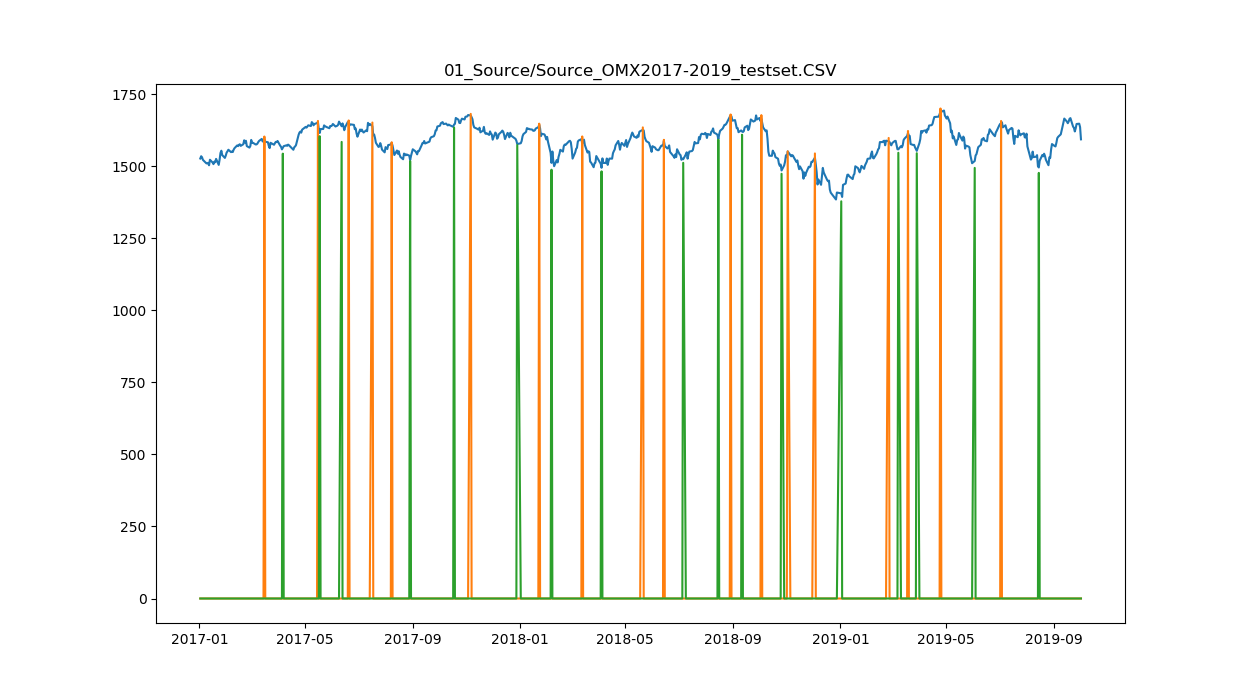

In [9]:
plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(source['Time'],source['Close'])
plt.plot(source['Time'], tops[:])
plt.plot(source['Time'], bottoms[:])
plt.title(filename)
plt.show()

In [10]:
#Calculate the latest single event from a list of [0 0 0 0 2 0 0 1 0]->[0 0 0 0 2 2 2 2 1 1]
def calculateLatestEvent(eventList):
    previousItem=0;
    result = np.zeros(eventList.shape[0])
    for i in range(len(eventList)):
        if eventList[i]!=previousItem and eventList[i]!= 0:
            result[i]=eventList[i]
            previousItem=eventList[i]
        else: 
            result[i]=previousItem
    return result

latestBottoms = calculateLatestEvent(bottoms)
latestTops = calculateLatestEvent(tops)

In [11]:
#Calculate varios MA
#mov = pd.Series(np.arange(0, 100, 1), name='test')
#print(mov)
#Moving Average 
# mov: close
# n: Number of samples
# shift: shift of the window. shift < 0 future, shift > 0 history
def MA(mov, n, shift):  
    MA = mov.rolling(n).mean()
    #print(MA)
    source=pd.DataFrame(MA)
    source.columns = ['SMA' + str(n) + 'shift' + str(shift)]
    shiftedMA = source.shift(shift)
    
    return shiftedMA

In [12]:
ma50Future = MA(close, 50, -50)

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


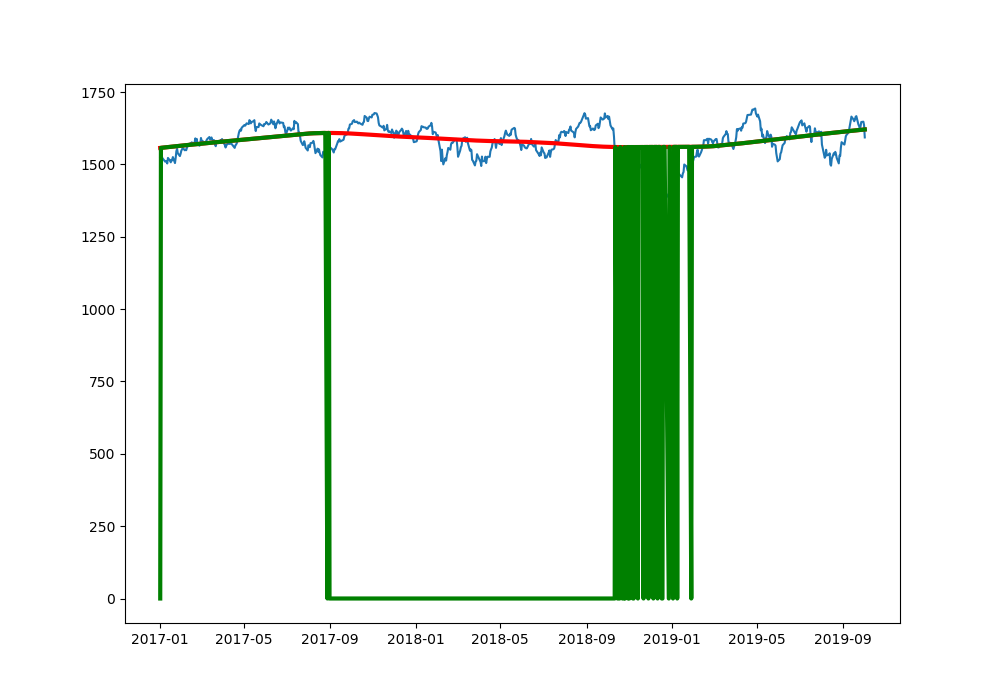

In [13]:
#Use Lowess to create a smoothed trend as an y value for a long trend
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
from scipy.ndimage.interpolation import shift

#Fraction for the lowess smoothing function
def calculate_lowess(days_to_consider, close, time):
    frac=days_to_consider/len(source['Close'])
    filtered = lowess(source['Close'], source['Time'], frac=frac)
    #Calculate the dlowess/dt to see if it is raising or declining
    shiftCol = filtered[:,1] - shift(filtered[:,1], 1, cval=np.NaN)
    pos_trend = shiftCol>0
    #print(pos_trend[0:5])

    fig = plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(source['Time'],source['Close'])
    plt.plot(source['Time'], filtered[:, 1], 'r-', linewidth=3)
    plt.plot(source['Time'], filtered[:, 1]*pos_trend, 'g-', linewidth=3)
    #plt.plot(source['Time'], filtered[:, 1]*pos_trend_cleaned, 'y-', linewidth=3)
    
    return pos_trend, fig

pos_trend_long, fig_long = calculate_lowess(300, source['Close'], source['Time'])
plt.gca()
plt.show()

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


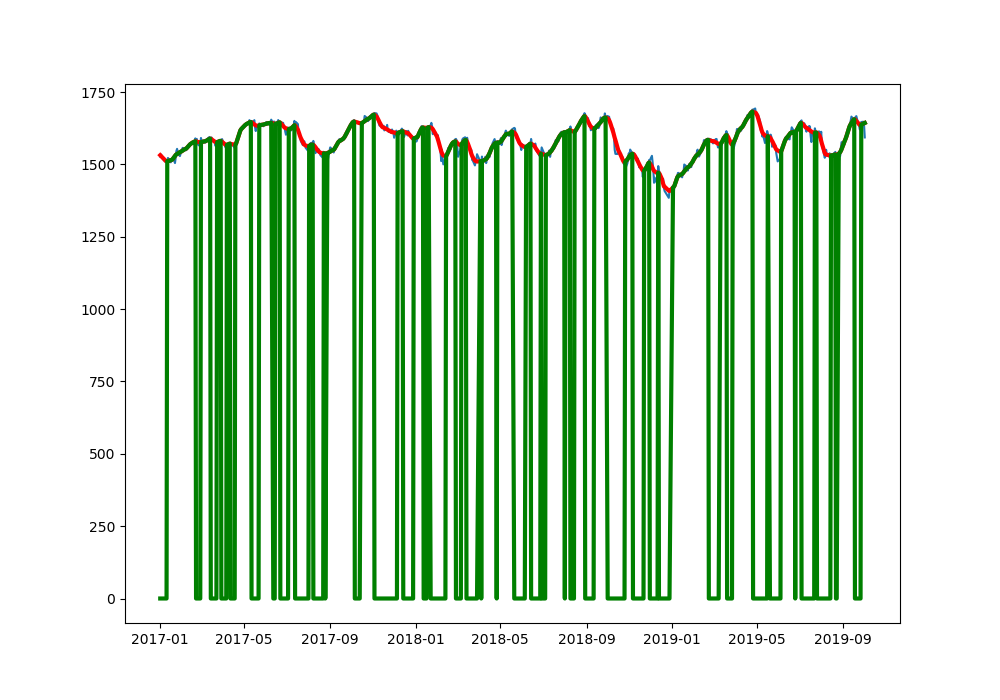

In [14]:
pos_trend_short, fig_short = calculate_lowess(10, source['Close'], source['Time'])
plt.gca()
plt.show()

### Calculate the Y values for 1d, 5d, 20d and the Long Trend

In [15]:
#Calculte the 1d trend

high=source['High']
low=source['Low']
close=source['Close']

y1day=np.zeros(m)
#Calculate the 5d trend
y5day=np.zeros(m)
#20d trend
y20day=np.zeros(m)
#long term trend
ylong=np.zeros(m)
signalLong=0;

for i in range(m-50):
    #=== 1d trend ===#
    if close[i+1]>close[i]:
        y1day[i]=1
    
    #=== 5day short trend ===#
    #if (pos_trend_short[i+10]==True) and (pos_trend_short[i+1]==True) and (pos_trend_short[i+2]==True) and (future_difference>0.001) and close[i+1]>close[i]:
    #Positive buy
    if i>5 and np.max(bottoms[i-5:i-1])>0 and np.mean(close[i+1:i+5])>close[i]:
        y5day[i]=1;
    
    #negtive, sell
    if i>5 and np.max(tops[i-5:i-1])>0 and np.mean(close[i+1:i+5])<close[i]:
        y5day[i]=2;
    
    #=== median trend 20d ===#
    if close[i+20]>close[i]:
        y20day[i]=1;
    
    #=== long term trend ===#
    #Trigger positive, buy
    if pos_trend_long[i] == True and close[i]>latestTops[i]:
        signalLong=1;
    #negative, sell
    elif pos_trend_long[i] == False and close[i]<latestBottoms[i]:
        signalLong=2;
    
    if signalLong==1:
        ylong[i] = 1;
    elif signalLong==2:
        ylong[i] = 2;
    else:
        ylong[i] = 0;

    #=== end ===#
print("y1day", sum(y1day))
print("y5day", sum(y5day))
print("y20day", sum(y20day))
print("ylong", sum(ylong))
print("Generated trends 1d, 5d, 20d, long.")

y1day 335.0
y5day 162.0
y20day 333.0
ylong 1003.0
Generated trends 1d, 5d, 20d, long.


In [16]:
#Clean bad signals 1
previousSignalCount = sum(y1day)
for i in range(m-50):
    #If the signal is only valid for one or 2 days the signal was bad and
    #noisy. Only if the signal is valid for 3 days, it can be consideres as
    #a real signal
    if np.mean(y1day[i:i+3])<0.75:
        y1day[i]=0

print("Previous signal count y1day={}. New signal count={}".format(previousSignalCount, sum(y1day)))
print("Cleaned bad signals 1");

Previous signal count y1day=335.0. New signal count=108.0
Cleaned bad signals 1


In [17]:
#Clean bad signals 2, filter single days, enhance trend
print("signals y1day=", sum(y1day))
print("signals ylong=", sum(ylong))

#for i in range(m-50):
    # short term +1d
    #if i>1 and y1day[i-1]==0 and y1day[i+1]==0:
    #    y1day[i]=0;
    
    #long term, remove all values < 5 days to remove noise
    #use sliding window
    #if i>5 and ylong[i]==1:
    #    slideresult = np.zeros(5);
    #    for j in range(-5,0):
    #        slideresult[j+5] = np.mean(ylong[i+j:i+j+4])
    #    
    #    if max(slideresult)<1:
    #        ylong[i]=0;

print("signals y1day=", sum(y1day))
print("signals ylong=", sum(ylong))
print("Cleaned bad signals 2");

signals y1day= 108.0
signals ylong= 1003.0
signals y1day= 108.0
signals ylong= 1003.0
Cleaned bad signals 2


In [18]:
#Clean bad signals 3, filter single days
print("signals ylong=", sum(ylong))
for i in range(m-50):
    #long term, fill in all values < 5 days to remove noise
    #Fill gaps
    #Use sliding window
    if i>20-1 and ylong[i]==0 and np.mean(ylong[i-20:i+20])>0.5:
        ylong[i]=1;
    
    #Enhance the trend to run as far as possible
    if i>=1 and ylong[i-1]==1 and ylong[i]==0 and close[i]>latestBottoms[i]:
        ylong[i]=1;

print("signals ylong=", sum(ylong))
print("Cleaned bad signals 3.");

signals ylong= 1003.0
signals ylong= 1003.0
Cleaned bad signals 3.


In [19]:
#Merge all y values to the series start
outcomes=source.join(
    pd.Series(y1day, name="1dTrend").astype('int64')).join(
    pd.Series(y5day, name="5dTrend").astype('int64')).join(
    pd.Series(y20day, name="20dTrend").astype('int64')).join(
    pd.Series(ylong, name="LongTrend").astype('int64'))
#result = [source array2table([tops bottoms y1day y5day y20day ylong], 'VariableNames',{'Tops', 'Bottoms', 'answer1d', 'answer5d', 'answer20d', 'answerLong'})];
#result(end-100:end,:)=[];

In [20]:
if cut_data == True:
    #Drop the 50 last values as they cannot be used for prediction as +50 days ahead is predicted
    outcomes_cut = outcomes.drop(outcomes.tail(50).index, inplace=False)
    #Drop from the timerows too
    source_cut = source.drop(source.tail(50).index, inplace=False)
else:
    source_cut = source
    outcomes_cut = outcomes

#fprintf("Finish\n");
display(outcomes_cut.head())
display(outcomes_cut.tail())
#merged_source.shape
#source.shape

,Time,High,Low,Close,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,,,,,
0,2017-01-02,1530.61,1510.67,1526.83,0,0,1,0
1,2017-01-03,1541.20,1526.26,1534.70,0,0,1,1
2,2017-01-04,1538.77,1527.59,1530.93,0,0,1,1
3,2017-01-05,1530.93,1521.88,1522.10,0,0,1,1
4,2017-01-09,1525.38,1504.07,1509.82,0,0,1,1


,Time,High,Low,Close,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,,,,,
686,2019-09-26,1635.69,1614.85,1631.61,0,0,0,0
687,2019-09-27,1646.70,1632.32,1646.60,0,0,0,0
688,2019-09-30,1652.09,1642.67,1647.67,0,0,0,0
689,2019-10-01,1658.99,1631.62,1635.64,0,0,0,0
690,2019-10-02,1634.53,1590.65,1593.32,0,0,0,0


In [21]:
#def amplifyForPlot(binaryArray, targetArray, distance):
#    return binaryArray * targetArray * (1-distance)
#amplifyForPlot(merged_df['LongTrend'], merged_df['Close'], 0.01)

#### Plot 3 class data

%matplotlib notebook

def plot_three_class_graph(y0, y1, y2, y_ref, y_time, offset1, offset2, offset3, legend):
    
    plot_data_OK = amplifyForPlot(y0, y_ref, offset1)
    plot_data_blim = amplifyForPlot(y1, y_ref, offset2)
    plot_data_tlim = amplifyForPlot(y2, y_ref, offset3)
    
    # Plot test data
    plt.figure(num=None, figsize=(11.5, 7), dpi=80, facecolor='w', edgecolor='k')

    plt.plot(y_time, y_ref)
    plt.plot(y_time, plot_data_OK, color='grey')
    plt.plot(y_time, plot_data_blim, color='green')
    plt.plot(y_time, plot_data_tlim, color='red')
    plt.title("Prediction Results")
    plt.ylim([np.min(y_ref)*0.99999, np.max(y_ref)*1.00002])
    plt.grid()
    plt.legend(legend)
    plt.show()

<IPython.core.display.Javascript object>


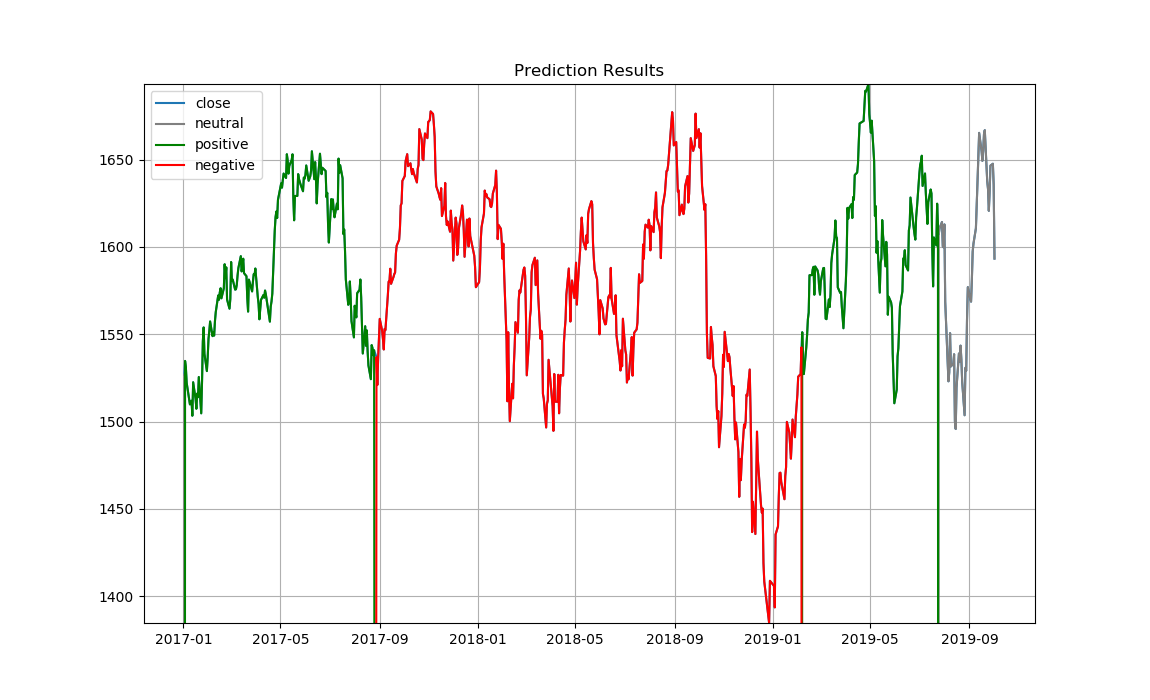

In [22]:
#Present long term term data
#y_order_data_ok = (outcomes_cut['LongTrend'].values==0)*1
#y_order_data_blim = (outcomes_cut['LongTrend'].values==1)*1
#y_order_data_tlim = (outcomes_cut['LongTrend'].values==2)*1
#plot_three_class_graph(y_order_data_ok, y_order_data_blim, y_order_data_tlim, source_cut['Close'], 
#                       source_cut['Time'], 0,0,0,('close', 'neutral', 'positive', 'negative'))
vis.plot_three_class_graph(outcomes_cut['LongTrend'].values, source_cut['Close'], 
                       source_cut['Time'], 0,0,0,('close', 'neutral', 'positive', 'negative'))

<IPython.core.display.Javascript object>


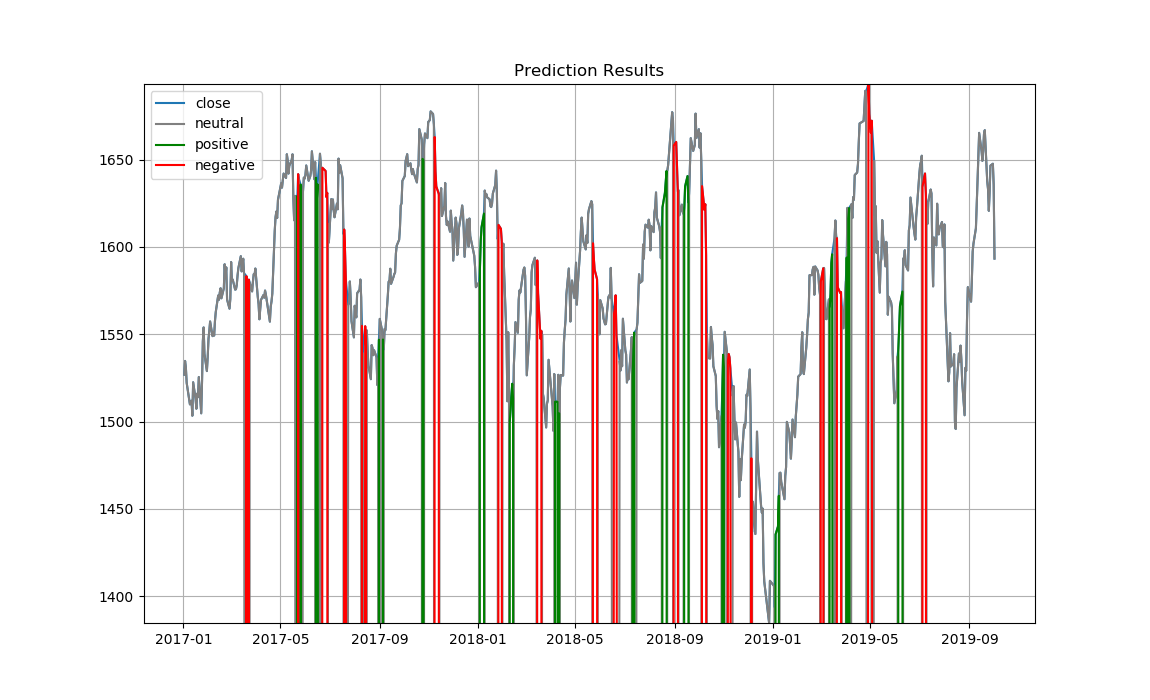

In [23]:
#Present short term data
#y_order_data_ok = (outcomes_cut['5dTrend'].values==0)*1
#y_order_data_blim = (outcomes_cut['5dTrend'].values==1)*1
#y_order_data_tlim = (outcomes_cut['5dTrend'].values==2)*1
#plot_three_class_graph(y_order_data_ok, y_order_data_blim, y_order_data_tlim, source_cut['Close'], 
#                       source_cut['Time'], 0,0,0,('close', 'close', 'bottom', 'top'))

vis.plot_three_class_graph(outcomes_cut['5dTrend'].values, source_cut['Close'], 
                       source_cut['Time'], 0,0,0,('close', 'neutral', 'positive', 'negative'))

#### Plot 2 class data

<IPython.core.display.Javascript object>


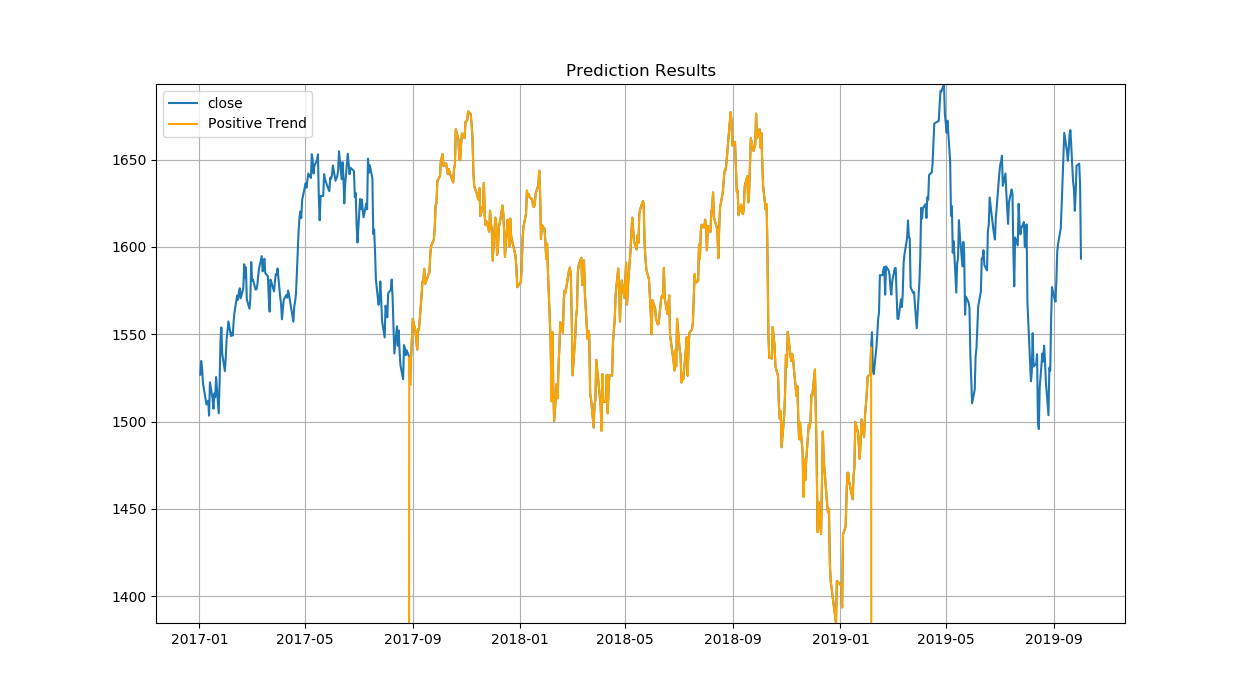

In [24]:
def plot_two_class_graph(binclass, y_ref, y_time, offset_binclass, legend):
    plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(y_time, y_ref)
    plt.plot(y_time,vis.amplifyForPlot(binclass, y_ref, offset_binclass), color='orange')
    plt.title(filename)
    plt.title("Prediction Results")
    plt.ylim([np.min(y_ref)*0.99999, np.max(y_ref)*1.00002])
    plt.grid()
    plt.legend(legend)
    plt.show()

plot_two_class_graph(outcomes_cut['LongTrend']-1, source_cut['Close'], source_cut['Time'], 0, ('close', 'Positive Trend'))

In [25]:
#Outcomes
#Rename cut outcomes to outcomes
outcomes = outcomes_cut
display(outcomes.head(5))

,Time,High,Low,Close,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,,,,,
0,2017-01-02,1530.61,1510.67,1526.83,0,0,1,0
1,2017-01-03,1541.20,1526.26,1534.70,0,0,1,1
2,2017-01-04,1538.77,1527.59,1530.93,0,0,1,1
3,2017-01-05,1530.93,1521.88,1522.10,0,0,1,1
4,2017-01-09,1525.38,1504.07,1509.82,0,0,1,1


## Generate Features from Raw Data
Generate features based on price data X

Data structure generated: features

In [26]:
#Inputs
close = outcomes['Close']
high = outcomes['High']
low = outcomes['Low']
yCol = outcomes['LongTrend'];

#Define features df
features = pd.DataFrame(index=outcomes.index)

In [27]:
def generate_smoothed_trigger(values, alpha=0.5, tailclip=0.1):
    ''' From a value array with signals in the range -1, 0, 1, generate smoothed decay'''
    
    smoothed_sign_change = np.zeros(values.shape)
    for i, value in enumerate(values):
        previous_value = 0.0
        if i>0:
            previous_value = smoothed_sign_change[i-1]
        if np.isnan(value):
            value = 0
        
        #Now use expoential smoothing to smooth the values 
        def exponential_smoothing(current_value, previous_value, alpha=alpha, tailclip=tailclip):
            new_value = current_value + (1-alpha) * previous_value
            if current_value==1 or current_value ==-1:
                new_value = current_value
            
            if new_value<-1:
                newValue = -1
            elif new_value>1:
                new_value = 1
            elif np.abs(new_value)<tailclip:
                new_value = 0
            
            return new_value
        
        smoothed_sign_change[i] = np.round(exponential_smoothing(value, previous_value, alpha=0.4, tailclip=0.1), 3)
        #print("new val: {}, Val: {}, prev val: {}".format(smoothed_sign_change[i], value, previous_value))
    
    return smoothed_sign_change

In [28]:
#Technical indicators necessary
#SMA200 = MA(close, 200, 0)
#bollinger = indicators(priceCol,'boll');
#rsi7=calc_RSI(priceCol,7)/100;
#rsi7 = [zeros(7,1);rsi7'];
#SMA200.fillna(0, inplace=True)
#SMA200



### Generate Price Based Values

#### Max and Min Price Values
Normalize the price compared to e.g. the last 200 days to find new highs and lows.

In [29]:
#5d, 20d, 100d, and 200d norm value from [0,1]

#list of normed days that are interesting
normed_days=[5, 20, 50, 100, 200]

normed_days_features = pd.DataFrame(index=features.index)

for d in normed_days:
    temp_col = np.zeros(close.shape)
    for i, c in enumerate(close[:]):
        if i>=d:
            min_value = np.min(close[i-d+1:i+1])
            max_value = np.max(close[i-d+1:i+1])
            current_value = close[i]
        
            normed_value  = (current_value-min_value)/(max_value - min_value)
            temp_col[i]=normed_value
        else:
            temp_col[i]=np.nan
        
        #display(close[i-4:i+1])
        #print(close[i])
        #normed_column = (close[i]-np.min(close[i-4:i+1]))/(np.max(close[i-5:i])-np.min(close[i-5:i]))
    
    normed_days_features = normed_days_features.join(pd.DataFrame(temp_col, columns=['NormKurs' + str(d)]))
#display(close[190:210])
#normed_days_features.iloc[190:210]

print("Number of features: {}".format(normed_days_features.shape))
features = features.join(normed_days_features)

display(normed_days_features.head(10))

Number of features: (691, 5)


,NormKurs5,NormKurs20,NormKurs50,NormKurs100,NormKurs200
id,,,,,
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,0.010852,NaN,NaN,NaN,NaN
6,0.097584,NaN,NaN,NaN,NaN
7,0.000000,NaN,NaN,NaN,NaN
8,1.000000,NaN,NaN,NaN,NaN


#### Number of last days increase/decrease

a = np.where(diff[0:20]>0)
a[0].shape[0]/20

In [30]:
#In the last 10days, the price increased x% of the time. 1=all days, 0=no days

#list of normed days that are interesting
number_days=[5, 20, 50, 100, 200]

number_days_features = pd.DataFrame(index=features.index)

diff = close-close.shift(1)

for n in number_days:
    temp_col = np.zeros(diff.shape)
    for i, c in enumerate(diff[:]):
        if i>=n:
            rise_value = np.where(diff[i-n+1:i+1]>0)[0].shape[0]/n
            temp_col[i]=rise_value
        else:
            temp_col[i]=np.nan
        
        #display(close[i-4:i+1])
        #print(close[i])
        #normed_column = (close[i]-np.min(close[i-4:i+1]))/(np.max(close[i-5:i])-np.min(close[i-5:i]))
    
    number_days_features = number_days_features.join(pd.DataFrame(temp_col, columns=['NumberRise' + str(n)]))
#display(close[0:20])
#normed_days_features.iloc[190:210]

print("Number of features: {}".format(number_days_features.shape))
features = features.join(number_days_features)

display(number_days_features.head(100))


Number of features: (691, 5)


,NumberRise5,NumberRise20,NumberRise50,NumberRise100,NumberRise200
id,,,,,
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,0.4,NaN,NaN,NaN,NaN
6,0.4,NaN,NaN,NaN,NaN
7,0.4,NaN,NaN,NaN,NaN
8,0.6,NaN,NaN,NaN,NaN


### Generate mean values

In [31]:
# Generate features - Mean value 
meanList = [2, 5, 8, 10, 13, 15, 18, 20, 22, 34, 40, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400];
#meanList = [5 10 20 50 100 1 50 200]';
#meanList = [5, 10, 20, 50, 100, 200];
#meanList = [5]

meanfeatures = pd.DataFrame(index=features.index)

for i in meanList:
    #Mean
    meanCol=MA(close, i, 0); #Trailing MA with i
    #meanCol.fillna(0, inplace=True)
    meanColreshaped = np.reshape(meanCol.values, (1,np.product(meanCol.values.shape)))[0]
    #Calculate diff from price in %
    diffPriceCol = np.divide(meanColreshaped - close.values, close.values)
    temp_source = pd.DataFrame(diffPriceCol, columns=['MA' + str(i) + 'Norm'])
    #print(temp_source)
    meanfeatures = meanfeatures.join(temp_source)
    #meanTable(:,i) = diffPriceCol;
    #print("Calculated MA{}".format(i));

print("Number of features: {}".format(meanfeatures.shape))

features = features.join(meanfeatures)

display(meanfeatures.head())

Number of features: (691, 26)


,MA2Norm,MA5Norm,MA8Norm,MA10Norm,MA13Norm,MA15Norm,MA18Norm,MA20Norm,MA22Norm,MA34Norm,...,MA175Norm,MA200Norm,MA225Norm,MA250Norm,MA275Norm,MA300Norm,MA325Norm,MA350Norm,MA375Norm,MA400Norm
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.002564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.002901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.004067,0.009972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Generate mean value directions

In [32]:
#Create empty dataframe for the differences between the current time and previous time
madiff_features = pd.DataFrame(index=features.index)

for col in meanfeatures.columns:
    currentCol = meanfeatures[col]
    shiftCol = meanfeatures[col].shift(1)
    diff = currentCol-shiftCol
    diff.name = col + 'Diff'
    #display(currentCol)
    #display(shiftCol)
    madiff_features = madiff_features.join(diff)
    
print("Number of features: {}".format(madiff_features.shape))

features = features.join(madiff_features)

display(madiff_features.head())

Number of features: (691, 26)


,MA2NormDiff,MA5NormDiff,MA8NormDiff,MA10NormDiff,MA13NormDiff,MA15NormDiff,MA18NormDiff,MA20NormDiff,MA22NormDiff,MA34NormDiff,...,MA175NormDiff,MA200NormDiff,MA225NormDiff,MA250NormDiff,MA275NormDiff,MA300NormDiff,MA325NormDiff,MA350NormDiff,MA375NormDiff,MA400NormDiff
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.003795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.001669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.001166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Generate RSI

In [33]:
from talib import RSI

rsiList = [2, 3, 5, 9, 10, 14, 20, 25];

rsi_features = pd.DataFrame(index=features.index)

for i in rsiList:
    #RSI
    rsiCol=RSI(close, timeperiod=i)
    #Make source
    temp_source = pd.DataFrame(rsiCol, columns=['RSI' + str(i)])
    #print(temp_source)
    rsi_features = rsi_features.join(temp_source)
    #print("Calculated RSI{}".format(i))

print("Number of features: {}".format(rsi_features.shape))

features = features.join(rsi_features)

display(rsi_features.head(10))

Number of features: (691, 8)


,RSI2,RSI3,RSI5,RSI9,RSI10,RSI14,RSI20,RSI25
id,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,67.611684,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26.860068,38.446507,NaN,NaN,NaN,NaN,NaN,NaN
4,10.035705,20.236565,NaN,NaN,NaN,NaN,NaN,NaN
5,12.447257,21.463384,24.651726,NaN,NaN,NaN,NaN,NaN
6,35.405603,31.882188,29.433454,NaN,NaN,NaN,NaN,NaN
7,10.084494,16.327076,21.331757,NaN,NaN,NaN,NaN,NaN
8,78.597500,68.280329,55.555636,NaN,NaN,NaN,NaN,NaN


### Generate RSI difference

In [34]:
#RSI shift, in which direction it is moving
rsi_values = rsiList
rsi_change_features = pd.DataFrame(index=features.index)

for period in rsi_values:
    rsi=RSI(close, timeperiod=period)
    #Other column, here the same column shifted to find out if the direction changes
    rsi_shift = rsi.shift(1)
    temp_rsi = pd.DataFrame(rsi-rsi_shift, columns=['RSI' + str(period) + '_diff'])
    rsi_change_features = rsi_change_features.join(temp_rsi)

print("Number of features: {}".format(rsi_change_features.shape))
    
features = features.join(rsi_change_features)
    
display(rsi_change_features.head(10))

Number of features: (691, 8)


,RSI2_diff,RSI3_diff,RSI5_diff,RSI9_diff,RSI10_diff,RSI14_diff,RSI20_diff,RSI25_diff
id,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-40.751616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-16.824363,-18.209942,NaN,NaN,NaN,NaN,NaN,NaN
5,2.411552,1.226819,NaN,NaN,NaN,NaN,NaN,NaN
6,22.958346,10.418804,4.781728,NaN,NaN,NaN,NaN,NaN
7,-25.321110,-15.555113,-8.101696,NaN,NaN,NaN,NaN,NaN
8,68.513006,51.953253,34.223879,NaN,NaN,NaN,NaN,NaN


### RSIx < value
If RSI3 < 2 give signal, buying signal

In [35]:
# If RSI3 < 2 give signal, buying signal
rsi_signal_features = pd.DataFrame(index=features.index)

rsi3=RSI(close, timeperiod=3)
rsi3_signal = (rsi3 < 2)*1
rsi3_decay_signal = generate_smoothed_trigger(rsi3_signal)
rsi_signal_features = rsi_signal_features.join(pd.DataFrame(rsi3_decay_signal, columns=['RSI' + str(3) + 'sign']))
#rsi_signal_features[rsi_signal_features['RSI3sign']>0]


print("Number of features: {}".format(rsi_signal_features.shape))
    
features = features.join(rsi_signal_features)
    
display(rsi_signal_features.head(10))
    

Number of features: (691, 1)


,RSI3sign
id,
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0


### Generate RSI5 Signal
### FIXME
If RSI5 < 50 and decreasing, then the probability is high that it goes < 20 too and the price is lower

In [36]:
rsi = rsi_features["RSI5"] 
rsi_diff = rsi_change_features["RSI5_diff"]

#rsi_break_through = pd.DataFrame(index=features.index)

#if previous value>50, this value<50 and diff <0
#rsi_break_through = np.logical_and(rsi.shift(1).values>50, rsi.values<50, rsi_diff.values<0)
#rsi5=RSI(close, timeperiod=5)
#Other column, here the same column shifted to find out if the direction changes
#rsi5shift = rsi5.shift(1)
#display(rsi5.iloc[0:20])
#display(rsi5shift.iloc[0:20])

#rsi5_change = pd.DataFrame(index=features.index)

#rsi5_change = (rsi5<50 and rsi5shift>50)
#display(rsi5_change[0:20])
    
#rsi5_change_smoothed = generate_smoothed_trigger(rsi5_change)
#macd_direction_change_features = macd_direction_change_features.join(pd.Series(data=smoothed_sign_change, name=col + 'DirChange'))
    
#macd_direction_change_features.iloc[90:100]



### Generate Stochastic

Parameter: fastk=13, slowk=8, slowd=3
Parameter: fastk=5, slowk=3, slowd=3
Parameter: fastk=21, slowk=7, slowd=7
Parameter: fastk=21, slowk=14, slowd=14
Parameter: fastk=3, slowk=14, slowd=14
Number of features: (691, 10)


<IPython.core.display.Javascript object>


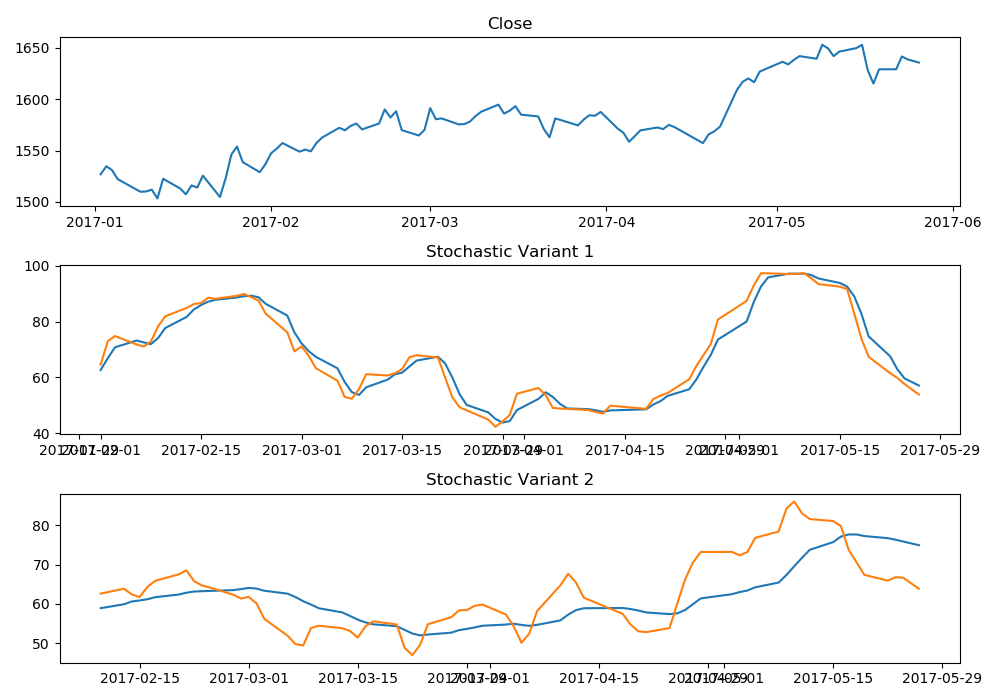

In [37]:
from talib import STOCH

#Recommended stochastics: [fk, sk, sd], [5,3,3], [21,7,7], [21,14,14]

fastk_parameter = [13, 5, 21, 21, 3]
slowk_parameter = [3, 3, 7, 14, 14]
slowd_parameter = [8, 3, 7, 14, 14]

stoch_features = pd.DataFrame(index=features.index)

for fk, sd, sk in zip(fastk_parameter, slowk_parameter, slowd_parameter):
    print("Parameter: fastk={}, slowk={}, slowd={}".format(fk, sk, sd))
    slowk, slowd = STOCH(high, low, close, fastk_period=fk, slowk_period=sk, slowk_matype=0, slowd_period=sd, slowd_matype=0)
    stoch_features = stoch_features.join(pd.DataFrame(slowk, columns=['Stoch_Sk' + str(fk)+str(sk)+str(sd)]))
    stoch_features = stoch_features.join(pd.DataFrame(slowd, columns=['Stoch_Sd' + str(fk)+str(sk)+str(sd)]))
#display(stoch_features.iloc[:,1].head(30))

print("Number of features: {}".format(stoch_features.shape))

features = features.join(stoch_features)

plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k') 
plt.subplot(311) 
plt.plot(source_cut['Time'][0:100],source_cut['Close'][0:100])
plt.title("Close")
plt.subplot(312)
plt.title("Stochastic Variant 1")
plt.plot(source_cut['Time'][0:100],stoch_features.iloc[:,1][0:100]) 
plt.plot(source_cut['Time'][0:100],stoch_features.iloc[:,0][0:100])
plt.subplot(313) 
plt.title("Stochastic Variant 2")
plt.plot(source_cut['Time'][0:100],stoch_features.iloc[:,-1][0:100]) 
plt.plot(source_cut['Time'][0:100],stoch_features.iloc[:,-2][0:100])
plt.tight_layout()

### MACD

Number of features: (691, 4)


<IPython.core.display.Javascript object>


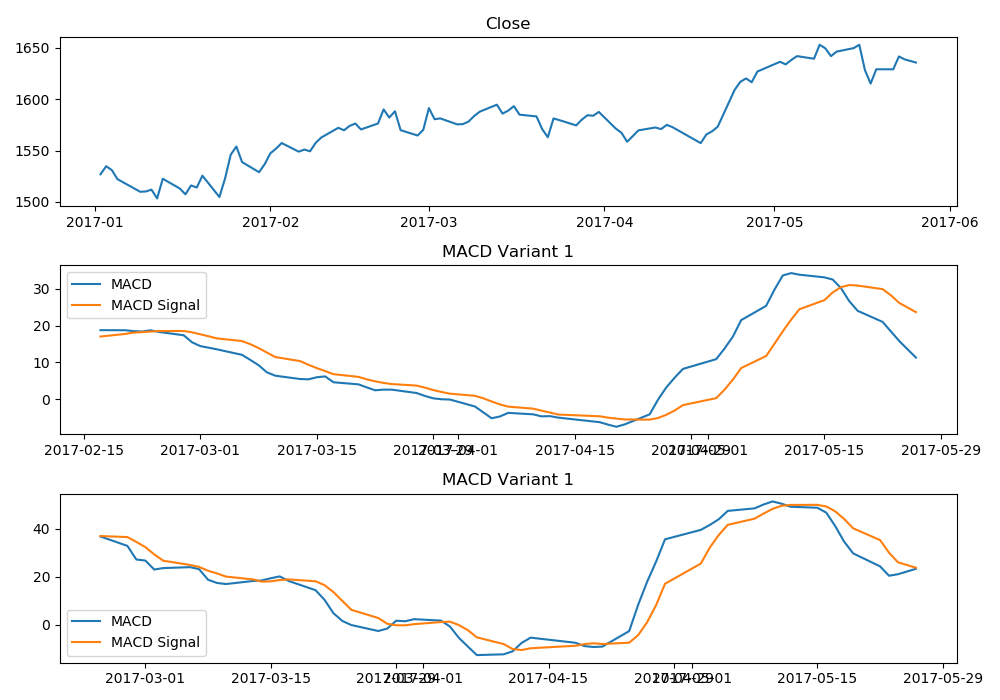

In [38]:
from talib import MACDEXT

#MACD
#Recommended parameters: 12_26_9, 5, 35, 5
fast_macd = [12, 5]
slow_macd = [26, 35]
signal_macd = [9, 5]

macd_features = pd.DataFrame(index=features.index)

for fmacd, smacd, sigmacd in zip(fast_macd, slow_macd, signal_macd):
    macd, macdsignal, macdhist = MACDEXT(close, fastperiod=fmacd, fastmatype=0, slowperiod=smacd, slowmatype=0, signalperiod=sigmacd, signalmatype=0)
    macd_features = macd_features.join(pd.DataFrame(macd, columns=['MACD' + str(fmacd) + "_" + str(smacd)+  "_" + str(sigmacd)]))
    macd_features = macd_features.join(pd.DataFrame(macdsignal, columns=['MACDsig' + str(fmacd) + "_" + str(smacd)+  "_" + str(sigmacd)]))

print("Number of features: {}".format(macd_features.shape))

features = features.join(macd_features)

plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k') 
plt.subplot(311) 
plt.plot(source_cut['Time'][0:100],source_cut['Close'][0:100])
plt.title("Close")
plt.subplot(312)
plt.title("MACD Variant 1")
plt.plot(source_cut['Time'][0:100], macd_features.iloc[:,0][0:100]) 
plt.plot(source_cut['Time'][0:100], macd_features.iloc[:,1][0:100])
plt.legend(("MACD", "MACD Signal"))
plt.subplot(313)
plt.title("MACD Variant 1")
plt.plot(source_cut['Time'][0:100], macd_features.iloc[:,-2][0:100]) 
plt.plot(source_cut['Time'][0:100], macd_features.iloc[:,-1][0:100])
plt.legend(("MACD", "MACD Signal"))
plt.tight_layout()

### MACD Difference

In [39]:
#MACD direction
#Create empty dataframe for the differences between the current time and previous time
macd_diff_features = pd.DataFrame(index=features.index)

for col in macd_features.columns:
    currentCol = macd_features[col]
    shiftCol = macd_features[col].shift(1)
    diff = currentCol-shiftCol
    diff.name = col + 'Diff'
    #display(currentCol)
    #display(shiftCol)
    macd_diff_features = macd_diff_features.join(diff)
    
print("Number of features: {}".format(macd_diff_features.shape))

features = features.join(macd_diff_features)

display(macd_diff_features.iloc[30:40])

Number of features: (691, 4)


,MACD12_26_9Diff,MACDsig12_26_9Diff,MACD5_35_5Diff,MACDsig5_35_5Diff
id,,,,
30,NaN,NaN,NaN,NaN
31,NaN,NaN,NaN,NaN
32,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN
34,-0.030769,0.705734,NaN,NaN
35,-0.234487,0.362949,NaN,NaN
36,-0.108141,0.127536,NaN,NaN
37,0.332179,0.145342,NaN,NaN
38,-0.433205,0.141873,NaN,NaN


### Signals for Trigger

In [40]:
#If MACD changes direction
macd_direction_change_features = pd.DataFrame(index=features.index)

for col in macd_diff_features.columns:
    #Column to find signal on
    currentCol = macd_diff_features[col]
    #Other column, here the same column shifted to find out if the direction changes
    shiftCol = macd_diff_features[col].shift(1)
    
    display(currentCol.iloc[90:100])
    #display(shiftCol.iloc[30:60])
    
    #Multiply current diff with previous diff and get the sign of the product. If sign is negative, then direction change
    #has occured. The multiply with the sign of the current value to get the sign of the direction change. If 1, then
    #it was a change from negative to positive. If it was negative, then it was a change from negative to positive
    signChange = (np.sign(currentCol*shiftCol)==-1)*1*np.sign(currentCol)
    display(signChange[90:100])
    
    smoothed_sign_change = generate_smoothed_trigger(signChange)
    macd_direction_change_features = macd_direction_change_features.join(pd.Series(data=smoothed_sign_change, name=col + 'DirChange'))

print("Number of features: {}".format(macd_direction_change_features.shape))

features = features.join(macd_direction_change_features)

macd_direction_change_features.iloc[90:100]

id
90   -0.436154
91   -0.711282
92   -0.594615
93   -2.358846
94   -3.523846
95   -2.580641
96   -3.002308
97   -2.592500
98   -2.591538
99   -4.466538
Name: MACD12_26_9Diff, dtype: float64

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sign
  app.launch_new_instance()


id
90   -1.0
91   -0.0
92   -0.0
93   -0.0
94   -0.0
95   -0.0
96   -0.0
97   -0.0
98   -0.0
99   -0.0
Name: MACD12_26_9Diff, dtype: float64

id
90    2.832336
91    2.460214
92    2.073383
93    1.455178
94    0.566766
95   -0.149088
96   -0.970377
97   -1.684772
98   -2.043526
99   -2.491346
Name: MACDsig12_26_9Diff, dtype: float64

id
90    0.0
91    0.0
92    0.0
93    0.0
94    0.0
95   -1.0
96   -0.0
97   -0.0
98   -0.0
99   -0.0
Name: MACDsig12_26_9Diff, dtype: float64

id
90   -1.277143
91   -0.412286
92   -2.060857
93   -5.646571
94   -6.514571
95   -4.851429
96   -5.405429
97   -3.922286
98    0.639429
99    2.261143
Name: MACD5_35_5Diff, dtype: float64

id
90   -0.0
91   -0.0
92   -0.0
93   -0.0
94   -0.0
95   -0.0
96   -0.0
97   -0.0
98    1.0
99    0.0
Name: MACD5_35_5Diff, dtype: float64

id
90    0.345943
91    0.052629
92   -0.681486
93   -2.067600
94   -3.182286
95   -3.897143
96   -4.895771
97   -5.268057
98   -4.010857
99   -2.255714
Name: MACDsig5_35_5Diff, dtype: float64

id
90    0.0
91    0.0
92   -1.0
93   -0.0
94   -0.0
95   -0.0
96   -0.0
97   -0.0
98   -0.0
99   -0.0
Name: MACDsig5_35_5Diff, dtype: float64

Number of features: (691, 4)


,MACD12_26_9DiffDirChange,MACDsig12_26_9DiffDirChange,MACD5_35_5DiffDirChange,MACDsig5_35_5DiffDirChange
id,,,,
90,-1.000,0.000,-0.600,0.000
91,-0.600,0.000,-0.360,0.000
92,-0.360,0.000,-0.216,-1.000
93,-0.216,0.000,-0.130,-0.600
94,-0.130,0.000,0.000,-0.360
95,0.000,-1.000,0.000,-0.216
96,0.000,-0.600,0.000,-0.130
97,0.000,-0.360,0.000,0.000
98,0.000,-0.216,1.000,0.000


In [41]:
#rsi5shift

### Periodical indicators

In [42]:
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

In [43]:
#Generate periodical values
periodic_values = pd.DataFrame(index=features.index)
timelist = source['Time']
# Get month of year
periodic_values['month_of_year'] = timelist.apply(lambda x: x.month)
# Get week of year
periodic_values['week_of_year'] = timelist.apply(lambda x: x.week)
# Get day of year
periodic_values['day_of_year'] = timelist.apply(lambda x: x.timetuple().tm_yday)
# Get day of month
periodic_values['day_of_month'] = timelist.apply(lambda x: x.day)
# Get day of week
periodic_values['day_of_week'] = timelist.apply(lambda x: x.weekday())
# Get week of month
periodic_values['week_of_month'] = timelist.apply(week_of_month)
display(periodic_values.head())

,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week,week_of_month
id,,,,,,
0,1,1,2,2,0,2
1,1,1,3,3,1,2
2,1,1,4,4,2,2
3,1,1,5,5,3,2
4,1,2,9,9,0,3


In [44]:
#Make one-hot-encoding of the values as they do not depend on each other
from sklearn.preprocessing import OneHotEncoder

#One hot encoding for day of week
periodic_values = periodic_values.join(pd.get_dummies(periodic_values['day_of_week'], prefix='day_week_')).drop(['day_of_week'], axis=1)
#For special weeks, there are day of week 5 and 6. Remove them, as they are special cases
periodic_values.drop(columns=['day_week__5', 'day_week__6'], errors='ignore', inplace=True)

#One hot encoding for month of year
periodic_values = periodic_values.join(pd.get_dummies(periodic_values['month_of_year'], prefix='month_year_')).drop(['month_of_year'], axis=1)

#One hot encoding week of month
periodic_values = periodic_values.join(pd.get_dummies(periodic_values['week_of_month'], prefix='week_month_')).drop(['week_of_month'], axis=1)

print("Number of features: {}".format(periodic_values.shape))

features = features.join(periodic_values)

display(periodic_values.head())
#onehot_encoder = OneHotEncoder(sparse=False)
i#nteger_encoded = integer_encoded.reshape(len(integer_encoded), 1)
#onehot_encoded = onehot_encoder.fit_transform(periodic_values['day_of_week'])
#print(onehot_encoded)

Number of features: (691, 26)


,week_of_year,day_of_year,day_of_month,day_week__0,day_week__1,day_week__2,day_week__3,day_week__4,month_year__1,month_year__2,...,month_year__9,month_year__10,month_year__11,month_year__12,week_month__1,week_month__2,week_month__3,week_month__4,week_month__5,week_month__6
id,,,,,,,,,,,,,,,,,,,,,
0,1,2,2,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,1,3,3,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,1,4,4,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,1,5,5,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,2,9,9,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


25

### Candlestick patterns

Link: https://mrjbq7.github.io/ta-lib/func_groups/pattern_recognition.html

In [45]:
from talib import CDL2CROWS, CDL3BLACKCROWS, CDL3INSIDE

#FIXME: Get Open and create the patterns


pattern1 = CDL2CROWS(close, high, low, close)
pattern1 = CDL3BLACKCROWS(close, high, low, close)
i = CDL3INSIDE(close, high, low, close)
display(np.sum(pattern1))

0

### Show Features

In [46]:
#Features structure
display(features.head(100))
display(features.shape)

,NormKurs5,NormKurs20,NormKurs50,NormKurs100,NormKurs200,NumberRise5,NumberRise20,NumberRise50,NumberRise100,NumberRise200,...,month_year__9,month_year__10,month_year__11,month_year__12,week_month__1,week_month__2,week_month__3,week_month__4,week_month__5,week_month__6
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
5,0.010852,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
6,0.097584,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
7,0.000000,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
8,1.000000,NaN,NaN,NaN,NaN,0.6,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0


(691, 127)

## Create files

### Clean NaNs

In [47]:
#Assign the columns to X and y
#Clean the featurestable and make an array or it
#Drop all NaN rows
nan_index = pd.isnull(features).any(1).nonzero()[0]
print("Found {} rows with NaN".format(len(nan_index)))
X=features.drop(nan_index)
#yName = 'LongTrend'
y=outcomes.drop(nan_index).drop(['Time', 'High', 'Low', 'Close'], axis=1)

Found 400 rows with NaN


### Merge X and y

In [48]:
#Merge X and y to one chart
dataset = X.join(y)

graphsource = source_cut.drop(nan_index)
#y=y.reshape(-1, 1)

#Create the matrix with features
#featureNames = features.columns.values

print("Got features X shape={}, y shape={}".format(X.shape, y.shape))
print("Dataset shape", dataset.shape)

Got features X shape=(291, 127), y shape=(291, 4)
Dataset shape (291, 131)


In [49]:
display(dataset.head(5))
display(dataset.tail(5))
display(graphsource.head(5))
display(graphsource.tail(5))

,NormKurs5,NormKurs20,NormKurs50,NormKurs100,NormKurs200,NumberRise5,NumberRise20,NumberRise50,NumberRise100,NumberRise200,...,week_month__1,week_month__2,week_month__3,week_month__4,week_month__5,week_month__6,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,,,,,,,,,,,,,,,,,,
400,1.000000,1.000000,1.000000,0.951672,0.684372,0.4,0.65,0.50,0.51,0.5,...,0,1,0,0,0,0,0,0,1,2
401,1.000000,1.000000,1.000000,0.972492,0.699344,0.6,0.70,0.52,0.52,0.5,...,0,1,0,0,0,0,0,0,1,2
402,1.000000,1.000000,1.000000,1.000000,0.746339,0.8,0.70,0.54,0.52,0.5,...,0,1,0,0,0,0,0,0,1,2
403,0.366593,0.816386,0.867665,0.894494,0.667596,0.6,0.65,0.54,0.51,0.5,...,0,1,0,0,0,0,0,0,1,2
404,0.000000,0.739614,0.821563,0.857739,0.640164,0.6,0.60,0.54,0.51,0.5,...,0,0,1,0,0,0,0,0,1,2


,NormKurs5,NormKurs20,NormKurs50,NormKurs100,NormKurs200,NumberRise5,NumberRise20,NumberRise50,NumberRise100,NumberRise200,...,week_month__1,week_month__2,week_month__3,week_month__4,week_month__5,week_month__6,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,,,,,,,,,,,,,,,,,,
686,0.236694,0.640843,0.793901,0.793901,0.800143,0.4,0.65,0.54,0.54,0.555,...,0,0,0,0,1,0,0,0,0,0
687,1.000000,0.793444,0.881470,0.881470,0.848698,0.4,0.65,0.54,0.55,0.560,...,0,0,0,0,1,0,0,0,0,0
688,1.000000,0.804337,0.887721,0.887721,0.852164,0.6,0.70,0.56,0.55,0.560,...,0,0,0,0,0,1,0,0,0,0
689,0.554444,0.634973,0.817444,0.817444,0.813196,0.6,0.70,0.54,0.55,0.560,...,1,0,0,0,0,0,0,0,0,0
690,0.000000,0.000000,0.570218,0.570218,0.676114,0.6,0.65,0.54,0.54,0.555,...,1,0,0,0,0,0,0,0,0,0


,Time,High,Low,Close
id,,,,
400,2018-08-07,1621.26,1610.52,1619.89
401,2018-08-08,1624.10,1614.73,1622.63
402,2018-08-09,1631.74,1618.72,1631.23
403,2018-08-10,1627.44,1613.39,1616.82
404,2018-08-13,1616.34,1607.81,1611.80


,Time,High,Low,Close
id,,,,
686,2019-09-26,1635.69,1614.85,1631.61
687,2019-09-27,1646.70,1632.32,1646.60
688,2019-09-30,1652.09,1642.67,1647.67
689,2019-10-01,1658.99,1631.62,1635.64
690,2019-10-02,1634.53,1590.65,1593.32


In [50]:
import csv

#Save dataset to a csv file
print("dataset shape {}".format(dataset.shape))
dataset.to_csv(dataset_filename, sep=';', index=True, header=True)
#np.savetxt(filenameprefix + "_y.csv", y, delimiter=";", fmt='%s')
print("Saved features to " + dataset_filename)

#Save the graph data for visualization of the results
print("source shape {}".format(graphsource.shape))
graphsource.to_csv(source_filename, sep=';', index=True, header=True)
#np.savetxt(filenameprefix + "_y.csv", y, delimiter=";", fmt='%s')
print("Saved source graph to " + source_filename)

#Save y labels to a csv file as a dict
print("Class labels length {}".format(len(y_labels)))
with open(ylabel_filename, 'w') as f:
    for key in y_labels.keys():
        f.write("%s;%s\n"%(key,y_labels[key]))
print("Saved class names and id to " + ylabel_filename)

print("=== Data for {} prepared to be trained ===". format(filenameprefix))

dataset shape (291, 131)
Saved features to 03_Test_Prepared_Data/omxs30_LongTrend_dataset_test.csv
source shape (291, 4)
Saved source graph to 03_Test_Prepared_Data/omxs30_LongTrend_timegraph_test.csv
Class labels length 3
Saved class names and id to 03_Test_Prepared_Data/omxs30_LongTrend_y_labels_test.csv
=== Data for omxs30_LongTrend prepared to be trained ===


# Debug and Experiment

## Lowess Estimation of the Main Trend

from statsmodels.nonparametric.smoothers_lowess import lowess

#df['Time'],df['Close']
#print(len(df['Close']))
frac=300/len(df['Close'])
filtered = lowess(df['Close'], df['Time'], frac=frac)
#frac2=50/len(df['Close'])
#filtered2 = lowess(filtered[:,1], df['Time'], frac=frac2)

#def amplifyForPlot(binaryArray, targetArray, distance):
#    return binaryArray * targetArray * (1-distance)

import numpy as np
from scipy.ndimage.interpolation import shift

shiftCol = filtered[:,1] - shift(filtered[:,1], 1, cval=np.NaN)
pos_trend = shiftCol>0
pos_trend
#squarer = lambda x: x
#vfunc = np.vectorize(squarer)
#vfunc(x)
#np.mapp([filtered[:, 1]*[len(shiftCol>0)

plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['Time'],df['Close'])
plt.plot(df['Time'], filtered[:, 1], 'r-', linewidth=3)
plt.plot(df['Time'], filtered[:, 1]*pos_trend, 'g-', linewidth=3)
#plt.plot(df['Time'], filtered[:, 1]*pos_trend_cleaned, 'y-', linewidth=3)

plt.show()

len(filtered[:, 1])

from talib import RSI, BBANDS, MACDEXT, STOCH, STOCHF

#RSI
rsi = RSI(df['Close'], timeperiod=14)
display(rsi[0:20])
#Bollinger Bands
up, mid, low = BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
display(up[0:20])
#MACD
macd, macdsignal, macdhist = MACDEXT(close, fastperiod=12, fastmatype=0, slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)
display(macd[20:40])
#Stockastics slow
slowk, slowd = STOCH(high, low, close, fastk_period=13, slowk_period=3, slowk_matype=0, slowd_period=8, slowd_matype=0)
display(slowk[20:40])
#Stochastics fast
fastk, fastd = STOCHF(high, low, close, fastk_period=13, fastd_period=8, fastd_matype=0)
display(fastk[20:40])

slowk, slowd = STOCH(high, low, close, fastk_period=13, slowk_period=3, slowk_matype=0, slowd_period=8, slowd_matype=0)
fastk, fastd = STOCHF(high, low, close, fastk_period=13, fastd_period=8, fastd_matype=0)

plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(311)
plt.plot(df['Time'][8000:-1],df['Close'][8000:-1])

plt.subplot(312)
plt.plot(df['Time'][8000:-1],slowk[8000:-1])
plt.plot(df['Time'][8000:-1],slowd[8000:-1])

plt.subplot(313)
plt.plot(df['Time'][8000:-1],fastk[8000:-1])
plt.plot(df['Time'][8000:-1],fastd[8000:-1])
#plt.plot(df['Time'][0:500],fastk[0:500])
#plt.plot(df['Time'][0:500],fastd[0:500])